# Schizophrenia Classification using Resting State FMRI

### Group Sparse Covariance Matrix -> Feedforward Multilayer Network Method

In [1]:
# Imports 
import numpy as np

import keras
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from keras_tqdm import TQDMNotebookCallback

import nilearn


Using TensorFlow backend.


### Step 1. Gather Data
Gather the FMRI and class label data used for the classification problem. The dataset used in this project was the COBRE dataset. This dataset features 146 resting state FMRI of schizophrenic and non schizophrenic subjects. These FMRI's will be used to classify whether a patient is schizophrenic or not.
***

In [5]:
# fetch dataset
dataset = nilearn.datasets.fetch_cobre(n_subjects=146, data_dir="/nfshome/sandbox/perceptron", url=None, verbose=1)

file_paths = dataset["func"]  #list of file names
confounds = dataset["confounds"]  #list of confound file names
phenotypes = dataset["phenotypic"] # Contains phenotypic information of patients, we only use schizophrenia diagnosis

# sort lists so they are all corresponding by file names 0-146
phenotypes.sort(0) 
file_paths.sort() 
confounds.sort()

# number 74 is misisng samples so it needs to be removed
del file_paths[74]                          
del confounds[74]

In [6]:
# get just the diagnosis information from the phenotypes
diagnosis = phenotypes['diagnosis']
diagnosis_converted = []
#this step is necessary to convert np.byte array into strings, and then fit those strings 
#into 2 categories: Schizophrenia or no Schizophrenia
for item in diagnosis:
    s = item.decode('UTF-8')
    if s != "None":
        diagnosis_converted.append(float(1))   #person has schizophrenia
    else:
        diagnosis_converted.append(float(0))   #person doesn't have schizophrenia

del diagnosis_converted[74]                                          

Y = np.array(diagnosis_converted)

### Step 2. Mask the FMRI data using probabilistic brain atlas
Our raw fmri data is very large with a total of over 3 million total voxels per FMRI scan. For this reason we mask the data using a brain atlas. We use a predefined probabilistic brain atlas called the MSDL atlas. This gives us 39 spatial reigons of interest and averages together our FMRI blood oxygen values for all the voxels in each these reigons of interest. This process significantly reduces the size of the data and other noisy factors.
***

In [ ]:
# this is a brain anatomical atlas template, that gives us brain reigons with their labels
msdl_atlas_dataset = nilearn.datasets.fetch_atlas_msdl(data_dir="/nfshome/sandbox")

In [ ]:
from nilearn import image
from nilearn import input_data
from sklearn.externals.joblib import Memory   # A "memory" to avoid recomputation
mem = Memory('nilearn_cache')

# mask the data, used the atlas template as the mask img.
masker = input_data.NiftiMapsMasker(
    msdl_atlas_dataset.maps, resampling_target="maps", detrend=True,
    low_pass=.5, high_pass=0.01, t_r=2.0, standardize=True,
    memory='nilearn_cache', memory_level=1, verbose=0)
masker.fit()

# for each of our fmri scams, compute confounds, transform them into mask, and append
# to time series list
subject_time_series = []
for file_path, confound in zip(file_paths, confounds):

    # Computing some confounds
    hv_confounds = mem.cache(image.high_variance_confounds)(
        file_path, n_confounds=10)

    region_ts = masker.transform(file_path,
                                 confounds=[hv_confounds, confound])
    subject_time_series.append(region_ts)

### Step 3. Compute covariance matrix of our FMRI masked data
Now that we have our 39 reigons of intrest, we compute a covariance matrix on our masked data. This allows us to obtain information on how our reigons of interest are connecting with each other.
***

In [ ]:
from nilearn.connectome import GroupSparseCovarianceCV 
gsc = GroupSparseCovarianceCV(verbose=1)
gsc.fit(subject_time_series)

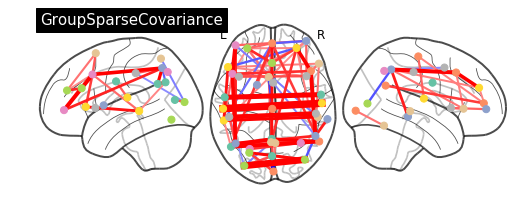

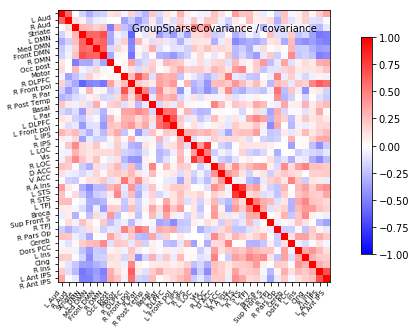

In [31]:
# Plot the correlation matrices and their corresponding connectomes
from nilearn import plotting
atlas_img = msdl_atlas_dataset.maps
atlas_region_coords = nilearn.plotting.find_probabilistic_atlas_cut_coords(atlas_img)
labels = msdl_atlas_dataset.labels


def plot_matrices(cov, title, labels):
    """Plot covariance and precision matrices, for a given processing. """

    # Display covariance matrix
    plotting.plot_matrix(cov, cmap=plotting.cm.bwr,
                         vmin=-1, vmax=1, title="%s / covariance" % title,
                         labels=labels)


title = "GroupSparseCovariance"
plotting.plot_connectome(-gsc.precisions_[..., 0],
                         atlas_region_coords, edge_threshold='90%',
                         title=title,
                         display_mode="lzr",
                         edge_vmax=.5, edge_vmin=-.5)
plot_matrices(gsc.covariances_[..., 0], title, labels)

plotting.show()

### Step 4. Prepare our data for the neural network
For this method, we take our covariance matrix and flatten it out into a 1d vector. The covariance matrix for each subject becomes our input to the neural network.
***

In [33]:
from nilearn.connectome import sym_matrix_to_vec

# Take the Covariance Matrix and flatten it into a 1d vector 
covar = gsc.covariances_
covar = np.swapaxes(covar, 0, 2)
X = sym_matrix_to_vec(covar, discard_diagonal=True)

In [64]:
# Split data into testing and training
x_train = X[:120]
x_test = X[120:]
y_train = Y[:120]
y_test = Y[120:]
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)

(120, 741)
(120,)
(25,)
(25, 741)


### Step 5. Neural Network
We create a multilayer feedforward neural network with 1 hidden layer of 350 units. The hidden layer has a relu activation function, and the output layer has a sigmoid activation function. A binary cross entropy loss function is used as this is a binary classification problem.

We employ a dropout layer with 10% dropout on the input layer in order to achieve slightly better generalization. We also use batch normalization to normalize hidden layer activations. 

In [65]:
input_dim=x_train.shape[1]
output_dim=1
# Multi-layer net with ReLU hidden layer
model = keras.models.Sequential()
model.add(keras.layers.Dropout(0.1, input_shape=(input_dim,)))
model.add(keras.layers.Dense(350,activation='relu',
                            bias_initializer=keras.initializers.Constant(0.1)))
model.add(keras.layers.BatchNormalization(momentum=0.8))
# Output layer (size 1), sigmoid activation function
model.add(keras.layers.Dense(output_dim,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])
# Display the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_33 (Dropout)         (None, 741)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 350)               259700    
_________________________________________________________________
batch_normalization_33 (Batc (None, 350)               1400      
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 351       
Total params: 261,451
Trainable params: 260,751
Non-trainable params: 700
_________________________________________________________________
None


In [66]:
batch_size = 110
epochs = 300
history = model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    validation_split=0.2)

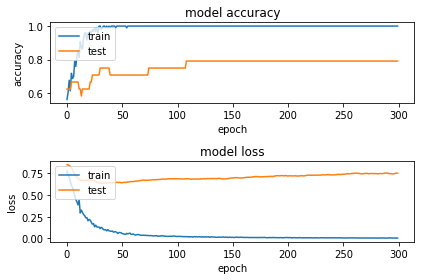

In [67]:
plt.figure()
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [68]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.4428662061691284
Test accuracy: 0.7200000286102295


# K Cross Validation
We use K Cross Validation to get accuracy over multiple class label splits

In [52]:
from sklearn.model_selection import StratifiedKFold
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=25, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
    model = keras.models.Sequential()
    model.add(keras.layers.Dropout(0.1, input_shape=(input_dim,)))
    model.add(keras.layers.Dense(350,activation='relu',
                                bias_initializer=keras.initializers.Constant(0.1)))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])
    batch_size = 110
    epochs = 300
    model.fit(X[train], Y[train],
        batch_size=batch_size,
        epochs=epochs,
        verbose=0)
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 83.33%
acc: 100.00%
acc: 83.33%
acc: 83.33%
acc: 50.00%
acc: 83.33%
acc: 66.67%
acc: 100.00%
acc: 66.67%
acc: 100.00%
acc: 50.00%
acc: 100.00%
acc: 83.33%
acc: 66.67%
acc: 66.67%
acc: 100.00%
acc: 100.00%
acc: 66.67%
acc: 83.33%
acc: 83.33%
acc: 83.33%
acc: 66.67%
acc: 80.00%
acc: 50.00%
acc: 50.00%
77.87% (+/- 16.78%)


## End Results:
We end up getting 77.87% (+/- 16.78%) accuracy with 25 K fold cross validation. This indicates that our network is picking up on differences between Schizophrenic and non-Schizohrenic resting state FMRI data.